In [20]:
import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.io import ascii, fits

from scipy.optimize import curve_fit

In [3]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=67.3, Om0=0.27, Tcmb0=2.725)

In [4]:
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import rc, rcParams
f = 0.8

fontsize = 35 * f
labelsize = 20 * f

rc("xtick", labelsize=fontsize * f)
rc("ytick", labelsize=fontsize * f)
rcParams["axes.linewidth"] = 5.3 * f
rcParams["xtick.major.width"] = 5.3 * f
rcParams["xtick.minor.width"] = 5.3 * f
rcParams["ytick.major.width"] = 5.3 * f
rcParams["ytick.minor.width"] = 5.3 * f
rcParams["xtick.major.size"] = 12.5 * f
rcParams["xtick.minor.size"] = 6.5 * f
rcParams["ytick.major.size"] = 12.5 * f
rcParams["ytick.minor.size"] = 6.5 * f

font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 50 * f,
        }


cm1 = plt.cm.get_cmap('jet')
cm2 = plt.cm.get_cmap('rainbow')
cm3 = plt.cm.get_cmap('gnuplot2')

color_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
colors1 = [cm1(value) for value in color_values]
colors2 = [cm2(value) for value in color_values]
colors3 = [cm3(value) for value in color_values]

In [143]:
imock_list = np.load("tables/testing-on-mocks/i_mock_list.npy")
ra0_list = np.load("tables/testing-on-mocks/ra0_list.npy")
dec0_list = np.load("tables/testing-on-mocks/dec0_list.npy")
z_cluster_list = np.load("tables/testing-on-mocks/z_cluster_list.npy")
m200_list = np.load("tables/testing-on-mocks/m200_list.npy")
r200_mpc_list = np.load("tables/testing-on-mocks/r200_mpc_list.npy")
r200_deg_list = np.load("tables/testing-on-mocks/r200_deg_list.npy")
cut_zp_list = np.load("tables/testing-on-mocks/cut_zp_list.npy")
w1_list = np.load("tables/testing-on-mocks/w1_list.npy")
w2_list = np.load("tables/testing-on-mocks/w2_list.npy")
alpha_list = np.load("tables/testing-on-mocks/alpha_list.npy")
cut_R_list = np.load("tables/testing-on-mocks/cut_R_list.npy")
c_zp_max_list = np.load("tables/testing-on-mocks/c_zp_max_list.npy")
p_zp_max_list = np.load("tables/testing-on-mocks/p_zp_max_list.npy")
c_R_max_list = np.load("tables/testing-on-mocks/c_R_max_list.npy")
p_R_max_list = np.load("tables/testing-on-mocks/p_R_max_list.npy")


v_esc = 927 * np.sqrt((m200_list / (1e14 * u.Msun / cosmo.h))) * np.sqrt((u.Mpc / cosmo.h) / r200_mpc_list/cosmo.h)
v_esc = v_esc.value #km s^{-1}

In [13]:
cut_zp_median = np.median(cut_zp_list[cut_zp_list != 0])
cut_R_median = np.median(cut_R_list[cut_R_list != 0][~np.isnan(cut_R_list[cut_R_list != 0])])

### Trying to find the best way of associating a P(C|R) and P(C|P(zp)) cuts to A168 and MKW4

In [144]:
#ESSA IDEIA AQUI NÃO DEU CERTO

def best_R_cut_chi2(w1_cluster, w2_cluster, alpha_cluster):
    '''
    The idea is to find among the mock clusters the one with a radial profile
    that minimizes the chi squared when comparing to the radial profile of the
    real cluster under consideration
    '''
    R = np.linspace(0, 5, 1000)[1:]

    rho_f = lambda R, w2: np.pi * w2 * R**2
    rho_c = lambda R, w1, alpha: 2 * np.pi * w1 * (R**(2 - alpha))/(2 - alpha)
    rho = lambda R, w1, w2, alpha: rho_c(R, w1, alpha) + rho_f(R, w2)

    rho_cluster = rho(R, w1_cluster, w2_cluster, alpha_cluster)

    chi2 = []
    for w1_m, w2_m, alpha_m in zip(w1_list, w2_list, alpha_list):
        rho_m = rho(R, w1_m, w2_m, alpha_m)

        chi2.append(np.sum((rho_cluster - rho_m)**2/rho_m))

    chi2 = np.array(chi2)

    best_R_cut_cluster = cut_R_list[np.argmin(chi2)]
    print("Most similar mock cluster = {}".format(imock_list[np.argmin(chi2)]))
    
    return best_R_cut_cluster

In [159]:
alpha_a168 = 0.97
w1_a168 = 0.08
w2_a168 = 0.03


alpha_mkw4 = 1.82
w1_mkw4 = 0.0
w2_mkw4 = 0.03

In [157]:
#ISSO AQUI DEU BEM MAIS CERTO

d_a168 = np.abs(alpha_a168 - alpha_list[cut_R_list != 0]) + np.abs(w1_a168 - w1_list[cut_R_list != 0]) + np.abs(w2_a168 - w2_list[cut_R_list != 0])
best_R_cut_a168 = cut_R_list[cut_R_list != 0][np.argmin(d_a168)]
print(best_R_cut_a168)
print(imock_list[cut_R_list != 0][np.argmin(d_a168)])


d_mkw4 = np.abs(alpha_mkw4 - alpha_list[cut_R_list != 0]) + np.abs(w1_mkw4 - w1_list[cut_R_list != 0]) + np.abs(w2_mkw4 - w2_list[cut_R_list != 0])
best_R_cut_mkw4 = cut_R_list[cut_R_list != 0][np.argmin(d_mkw4)]
print(best_R_cut_mkw4)
print(imock_list[cut_R_list != 0][np.argmin(d_mkw4)])

0.89
39
0.44
4


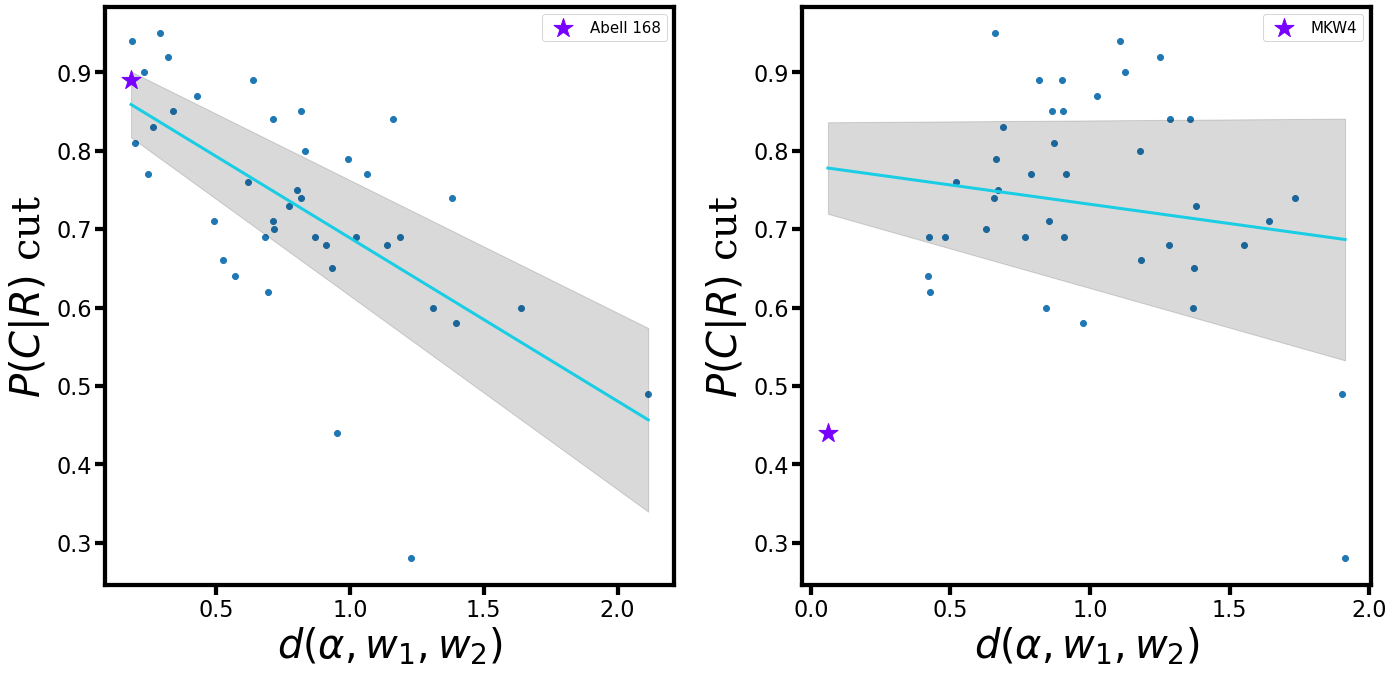

In [167]:
fig = plt.figure(figsize=(20, 10))

ax1 = fig.add_subplot(121)

x = d_a168
y = cut_R_list[cut_R_list != 0]

popt, cov = curve_fit(f1, x, y)
a, b = popt
sigma = np.sqrt(np.diagonal(cov))

ax1.scatter(x, y)

x_new = np.linspace(x.min(), x.max(), 100)
ax1.plot(x_new, f1(x_new, a, b), '-', lw=3, color=colors2[2])
bound_upper = f1(x_new, *(popt + sigma))
bound_lower = f1(x_new, *(popt - sigma))
# plotting the confidence intervals
ax1.fill_between(x_new, bound_lower, bound_upper, color ='black', alpha=0.15)

ax1.set_xlabel(r"$d(\alpha, w_1, w_2)$", fontdict=font)
ax1.set_ylabel(r"$P(C|R)$ cut", fontdict=font)
ax1.scatter(d_a168[np.argmin(d_a168)], cut_R_list[cut_R_list != 0][np.argmin(d_a168)], label="Abell 168", marker='*', s=400, color=colors3[3])
ax1.legend(fontsize=15)


ax2 = fig.add_subplot(122)

x = d_mkw4
y = cut_R_list[cut_R_list != 0]

popt, cov = curve_fit(f1, x, y)
a, b = popt
sigma = np.sqrt(np.diagonal(cov))

ax2.scatter(x, y)

x_new = np.linspace(x.min(), x.max(), 100)
ax2.plot(x_new, f1(x_new, a, b), '-', lw=3, color=colors2[2])
bound_upper = f1(x_new, *(popt + sigma))
bound_lower = f1(x_new, *(popt - sigma))
# plotting the confidence intervals
ax2.fill_between(x_new, bound_lower, bound_upper, color ='black', alpha=0.15)

ax2.set_xlabel(r"$d(\alpha, w_1, w_2)$", fontdict=font)
ax2.set_ylabel(r"$P(C|R)$ cut", fontdict=font)
ax2.scatter(d_mkw4[np.argmin(d_mkw4)], cut_R_list[cut_R_list != 0][np.argmin(d_mkw4)], label="MKW4", marker='*', s=400, color=colors3[3])
ax2.legend(fontsize=15)


fig.tight_layout(pad=3.0)

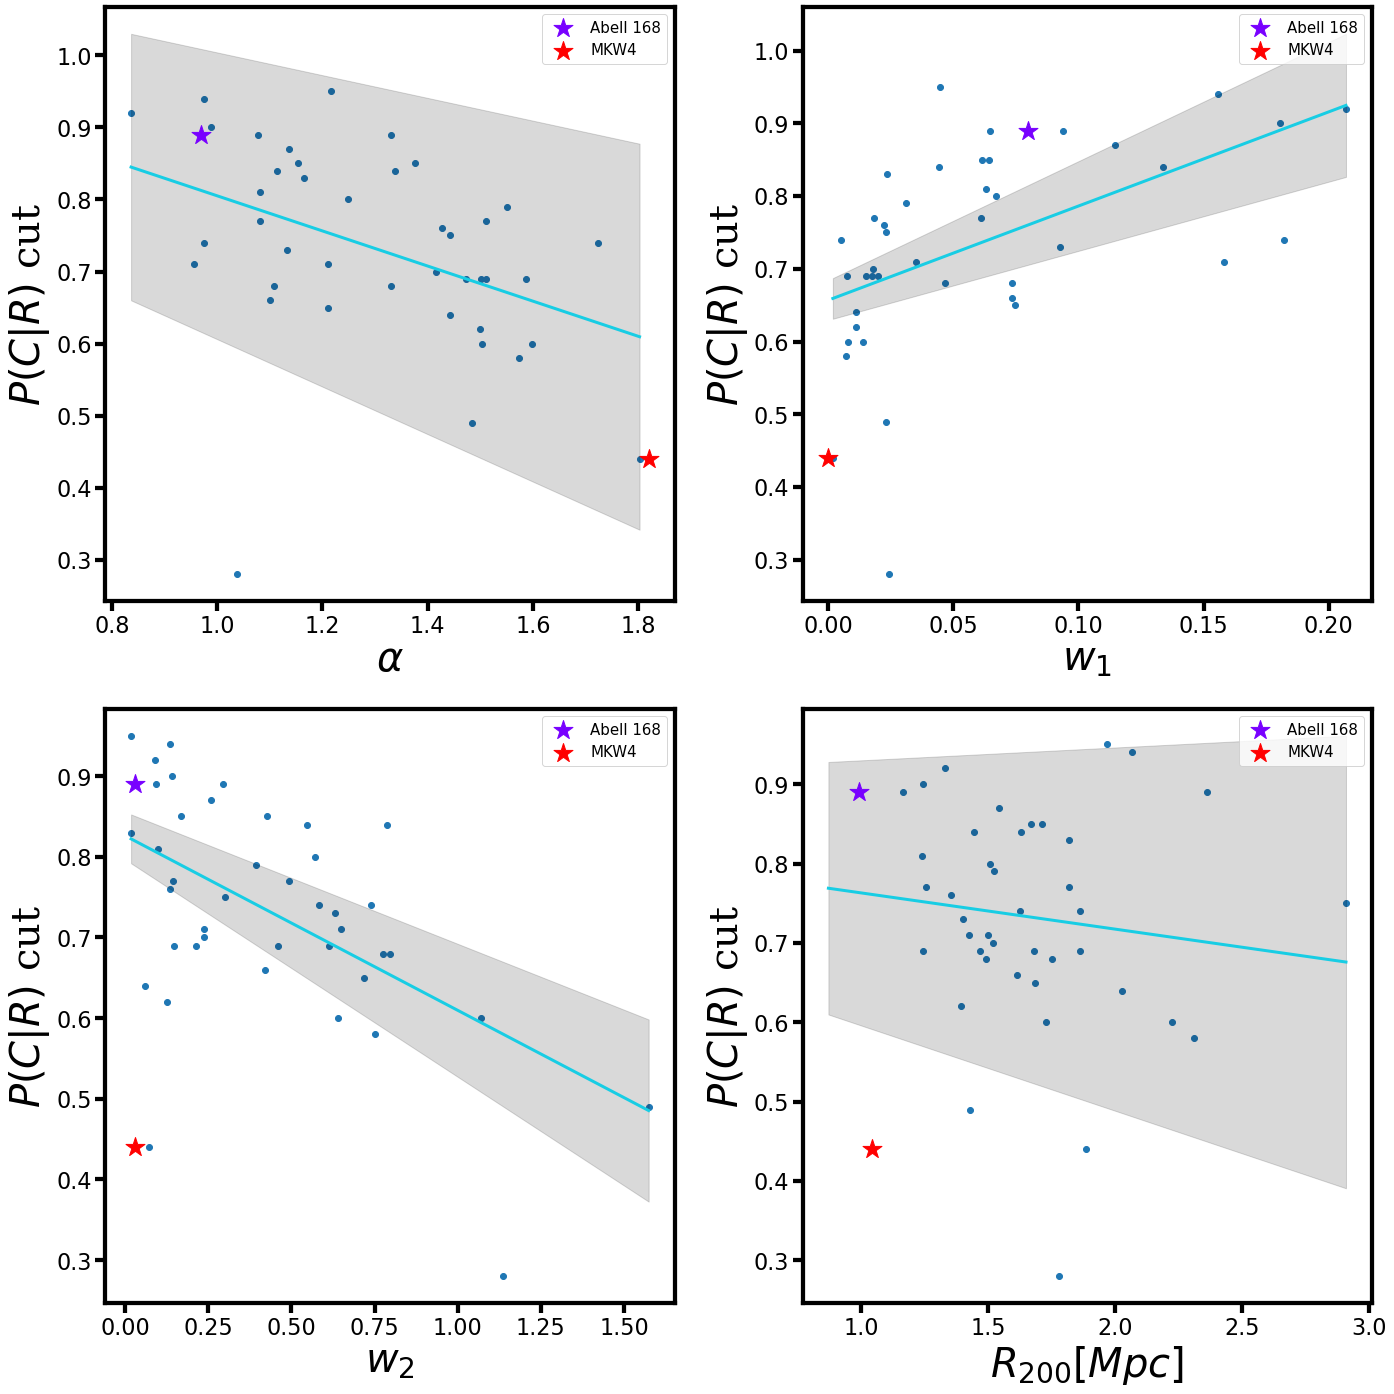

In [158]:
f1 = lambda x, a, b: a*x + b
f2 = lambda x, a, b, c: a*x**2 + b*x + c
fig = plt.figure(figsize=(20, 20))

#Plot 1
ax1 = fig.add_subplot(221)

x = alpha_list[cut_R_list != 0][~np.isnan(cut_R_list[cut_R_list != 0])]
y = cut_R_list[cut_R_list != 0][~np.isnan(cut_R_list[cut_R_list != 0])]

popt, cov = curve_fit(f1, x, y)
a, b = popt
sigma = np.sqrt(np.diagonal(cov))

ax1.scatter(x, y)

x_new = np.linspace(x.min(), x.max(), 100)
ax1.plot(x_new, f1(x_new, a, b), '-', lw=3, color=colors2[2])
bound_upper = f1(x_new, *(popt + sigma))
bound_lower = f1(x_new, *(popt - sigma))
# plotting the confidence intervals
ax1.fill_between(x_new, bound_lower, bound_upper, color ='black', alpha=0.15)

ax1.set_xlabel(r"$\alpha$", fontdict=font)
ax1.set_ylabel(r"$P(C|R)$ cut", fontdict=font)
ax1.scatter(alpha_a168, best_R_cut_a168, label="Abell 168", marker='*', s=400, color=colors3[3])
ax1.scatter(alpha_mkw4, best_R_cut_mkw4, label="MKW4", marker='*', s=400, color=colors2[9])
ax1.legend(fontsize=15)


#Plot 2
ax2 = fig.add_subplot(222)

x = w1_list[cut_R_list != 0][~np.isnan(cut_R_list[cut_R_list != 0])]

popt, cov = curve_fit(f1, x, y)
a, b = popt
sigma = np.sqrt(np.diagonal(cov))

ax2.scatter(x, y)

x_new = np.linspace(x.min(), x.max(), 100)
ax2.plot(x_new, f1(x_new, a, b), '-', lw=3, color=colors2[2])
bound_upper = f1(x_new, *(popt + sigma))
bound_lower = f1(x_new, *(popt - sigma))
# plotting the confidence intervals
ax2.fill_between(x_new, bound_lower, bound_upper, color ='black', alpha=0.15)

ax2.set_xlabel(r"$w_1$", fontdict=font)
ax2.set_ylabel(r"$P(C|R)$ cut", fontdict=font)
ax2.scatter(w1_a168, best_R_cut_a168, label="Abell 168", marker='*', s=400, color=colors3[3])
ax2.scatter(w1_mkw4, best_R_cut_mkw4, label="MKW4", marker='*', s=400, color=colors2[9])
ax2.legend(fontsize=15)


#Plot 3
ax3 = fig.add_subplot(223)

x = w2_list[cut_R_list != 0][~np.isnan(cut_R_list[cut_R_list != 0])]

popt, cov = curve_fit(f1, x, y)
a, b = popt
sigma = np.sqrt(np.diagonal(cov))

ax3.scatter(x, y)

x_new = np.linspace(x.min(), x.max(), 100)
ax3.plot(x_new, f1(x_new, a, b), '-', lw=3, color=colors2[2])
bound_upper = f1(x_new, *(popt + sigma))
bound_lower = f1(x_new, *(popt - sigma))
# plotting the confidence intervals
ax3.fill_between(x_new, bound_lower, bound_upper, color ='black', alpha=0.15)

ax3.set_xlabel(r"$w_2$", fontdict=font)
ax3.set_ylabel(r"$P(C|R)$ cut", fontdict=font)
ax3.scatter(w2_a168, best_R_cut_a168, label="Abell 168", marker='*', s=400, color=colors3[3])
ax3.scatter(w2_mkw4, best_R_cut_mkw4, label="MKW4", marker='*', s=400, color=colors2[9])
ax3.legend(fontsize=15)


#Plot 4
ax4 = fig.add_subplot(224)

x = r200_mpc_list[cut_R_list != 0][~np.isnan(cut_R_list[cut_R_list != 0])]

popt, cov = curve_fit(f1, x, y)
a, b = popt
sigma = np.sqrt(np.diagonal(cov))

ax4.scatter(x, y)

x_new = np.linspace(0.869956, x.max(), 100)
ax4.plot(x_new, f1(x_new, a, b), '-', lw=3, color=colors2[2])
bound_upper = f1(x_new, *(popt + sigma))
bound_lower = f1(x_new, *(popt - sigma))
# plotting the confidence intervals
ax4.fill_between(x_new, bound_lower, bound_upper, color ='black', alpha=0.15)


ax4.set_xlabel(r"$R_{200} [Mpc]$", fontdict=font)
ax4.set_ylabel(r"$P(C|R)$ cut", fontdict=font)
ax4.scatter(0.989478, best_R_cut_a168, label="Abell 168", marker='*', s=400, color=colors3[3])
ax4.scatter(1.040702, best_R_cut_mkw4, label="MKW4", marker='*', s=400, color=colors2[9])
ax4.legend(fontsize=15)

fig.tight_layout(pad=3.0)

In [138]:
# def best_zp_cut(m200, r200):

m200_mkw4 = 1.307594e14 #Msun
r200_mkw4 = 1.040702

v_esc_mkw4 = 927 * np.sqrt((m200_mkw4 / (1e14 * u.Msun))) * np.sqrt((u.Mpc) / r200_mkw4)

print(cut_zp_list[np.argmin(np.abs(v_esc_mkw4.value - v_esc))])


m200_a168 = 0.986235e14 #Msun
r200_a168 = 0.940114

v_esc_a168 = 927 * np.sqrt((m200_a168 / (1e14 * u.Msun))) * np.sqrt((u.Mpc) / r200_a168)

cut_zp_list[np.argmin(np.abs(v_esc_a168.value - v_esc))]

0.86


0.86

### Distribution of purity, completeness and of the cuts

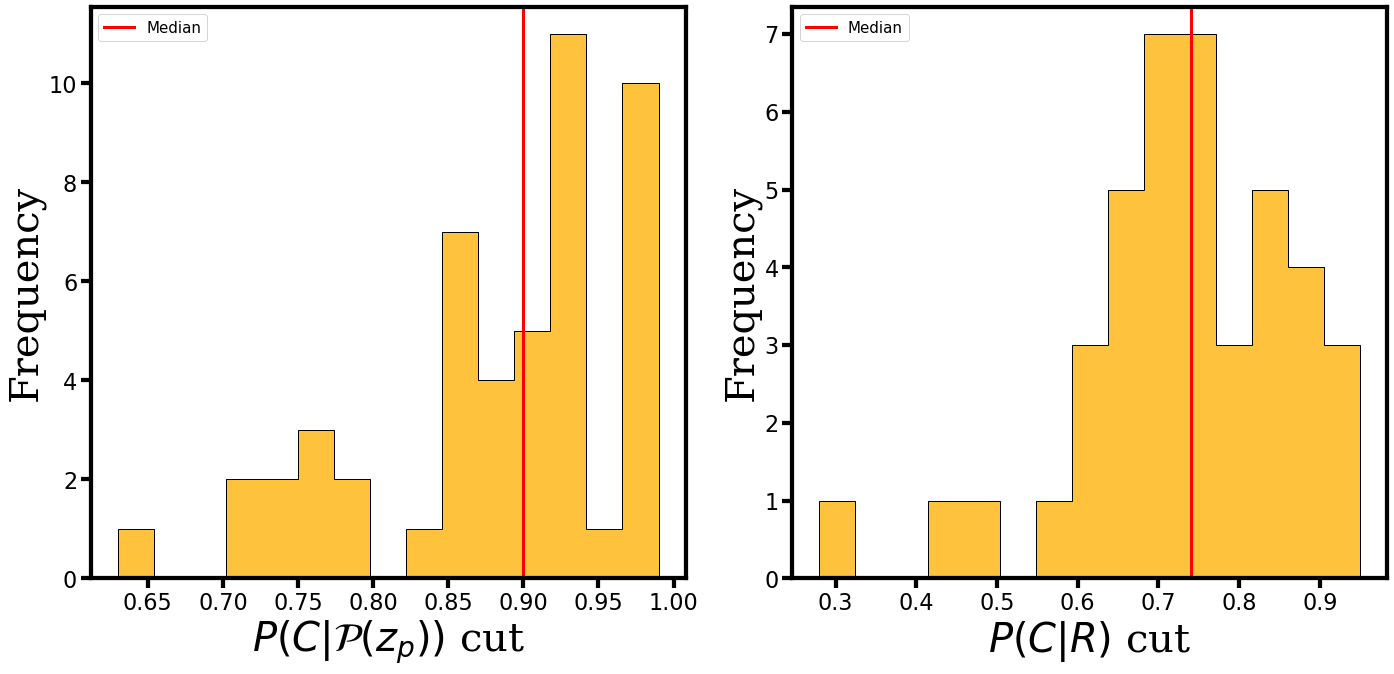

In [20]:
fig = plt.figure(figsize=(20, 10))

ax1 = fig.add_subplot(121)
ax1.hist(cut_zp_list[cut_zp_list != 0], bins=15, color=colors3[7], histtype='stepfilled', edgecolor='k')[2]
ax1.axvline(cut_zp_median, color="red", lw=3, label="Median")
ax1.set_xlabel(r"$P(C|\mathcal{P}(z_p))$ cut", fontdict=font)
ax1.set_ylabel("Frequency", fontdict=font)
ax1.legend(fontsize=15, loc=2)

ax2 = fig.add_subplot(122)
ax2.hist(cut_R_list[cut_R_list != 0], bins=15, color=colors3[7], histtype='stepfilled', edgecolor='k')[2]
ax2.axvline(cut_R_median, color="red", lw=3, label="Median")
ax2.set_xlabel(r"$P(C|R)$ cut", fontdict=font)
ax2.set_ylabel("Frequency", fontdict=font)
ax2.legend(fontsize=15, loc=2)


fig.tight_layout(pad=3.0)

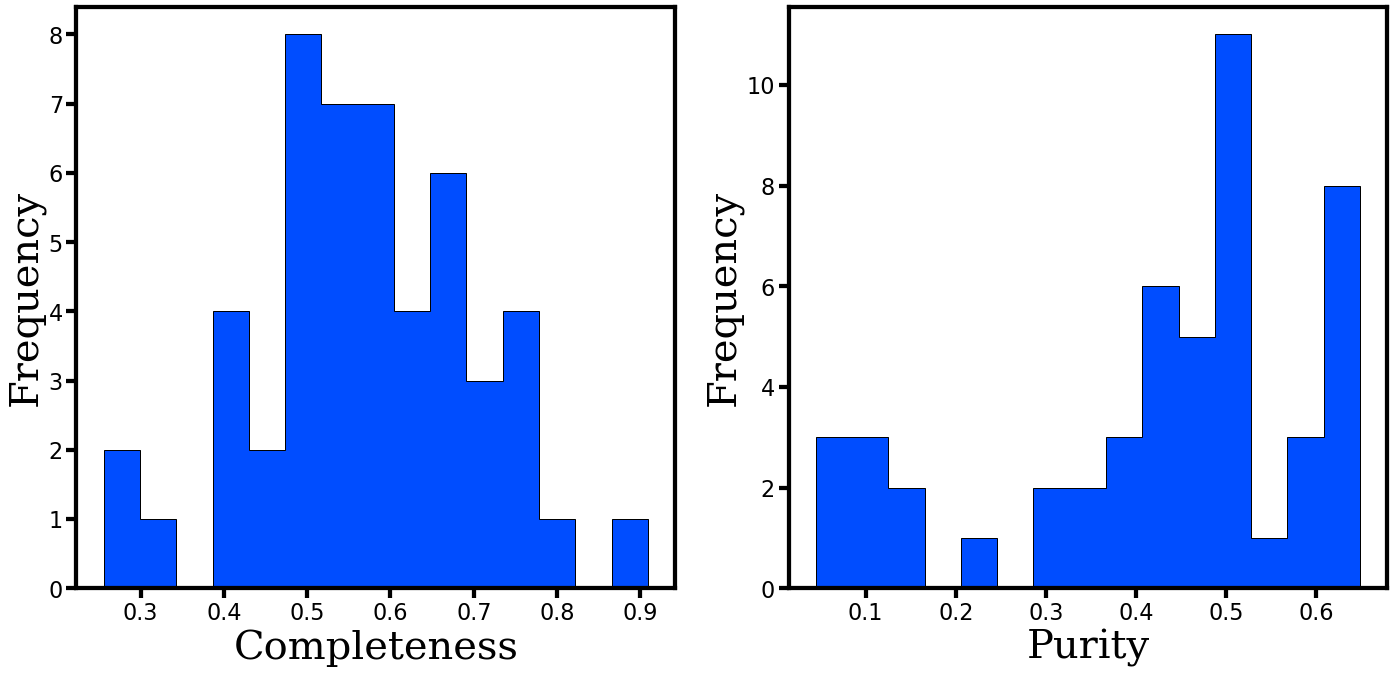

In [11]:
fig = plt.figure(figsize=(20, 10))

ax1 = fig.add_subplot(121)
ax1.hist(c_R_max_list, bins=15, color=colors1[1], histtype='stepfilled', edgecolor='k')[2]
# ax1.axvline(cut_zp_median, color="red", lw=3, label="Median")
ax1.set_xlabel("Completeness", fontdict=font)
ax1.set_ylabel("Frequency", fontdict=font)
# ax1.legend(fontsize=15, loc=2)

ax2 = fig.add_subplot(122)
ax2.hist(p_R_max_list, bins=15, color=colors1[1], histtype='stepfilled', edgecolor='k')[2]
# ax1.axvline(cut_zp_median, color="red", lw=3, label="Median")
ax2.set_xlabel("Purity", fontdict=font)
ax2.set_ylabel("Frequency", fontdict=font)
# ax1.legend(fontsize=15, loc=2)


fig.tight_layout(pad=3.0)

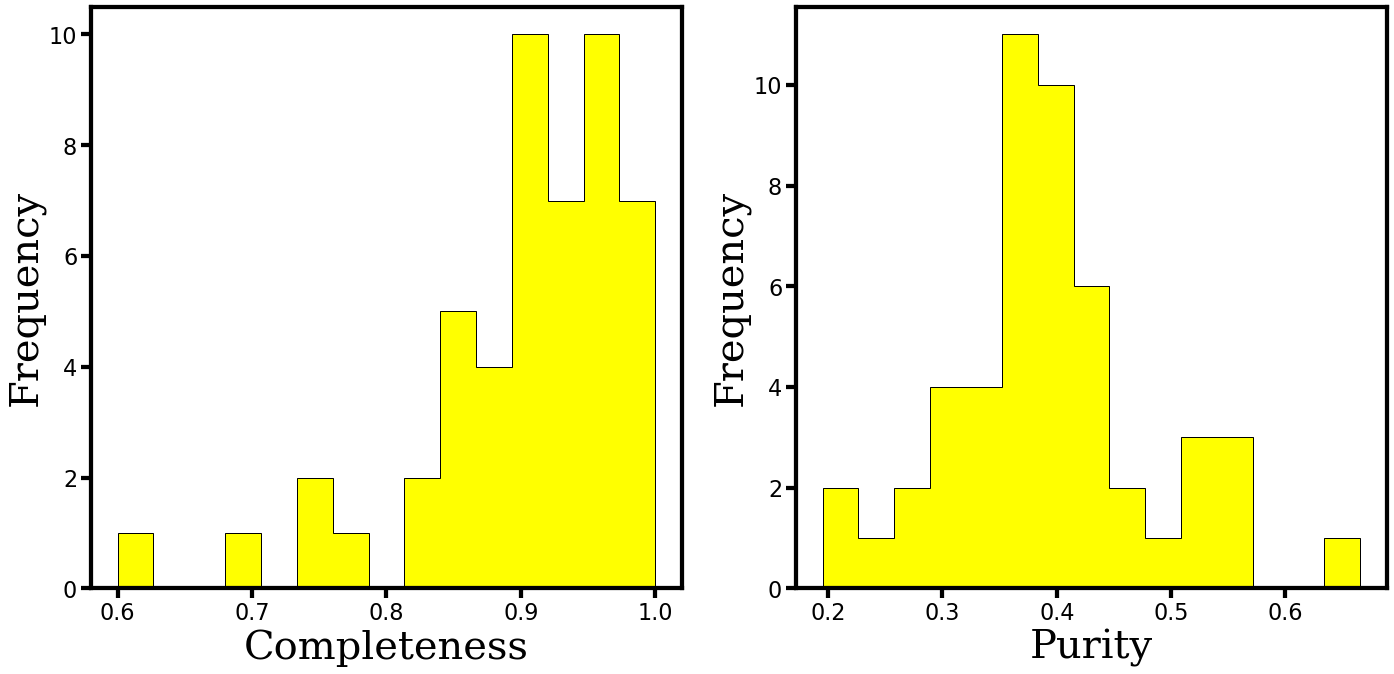

In [12]:
fig = plt.figure(figsize=(20, 10))

ax1 = fig.add_subplot(121)
ax1.hist(c_zp_max_list, bins=15, color="yellow", histtype='stepfilled', edgecolor='k')[2]
# ax1.axvline(cut_zp_median, color="red", lw=3, label="Median")
ax1.set_xlabel("Completeness", fontdict=font)
ax1.set_ylabel("Frequency", fontdict=font)
# ax1.legend(fontsize=15, loc=2)

ax2 = fig.add_subplot(122)
ax2.hist(p_zp_max_list, bins=15, color="yellow", histtype='stepfilled', edgecolor='k')[2]
# ax1.axvline(cut_zp_median, color="red", lw=3, label="Median")
ax2.set_xlabel("Purity", fontdict=font)
ax2.set_ylabel("Frequency", fontdict=font)
# ax1.legend(fontsize=15, loc=2)


fig.tight_layout(pad=3.0)

### Distribution of properties of the mock clusters

In [30]:
hdul = fits.open("cluster-mocks/lightcone_zphot_subhalos_AllFrom1.fits")
scat = hdul[1].data

magr = scat["mag_r"]
mask_mag = magr < 21

haloId = scat["haloId"][mask_mag]
galaxyId = scat["galaxyId"][mask_mag]
z_phot_original = scat["z_phot"][mask_mag]
z_spec = scat["z_app"][mask_mag]
ra = scat["RA"][mask_mag]
dec = scat["DEC"][mask_mag]
magr = scat["mag_r"][mask_mag]
magu = scat["mag_u"][mask_mag]
magg = scat["mag_g"][mask_mag]
magi = scat["mag_i"][mask_mag]
magz = scat["mag_z"][mask_mag]
firstHaloinFoFGroupId = scat["firstHaloinFoFGroupId"][mask_mag]

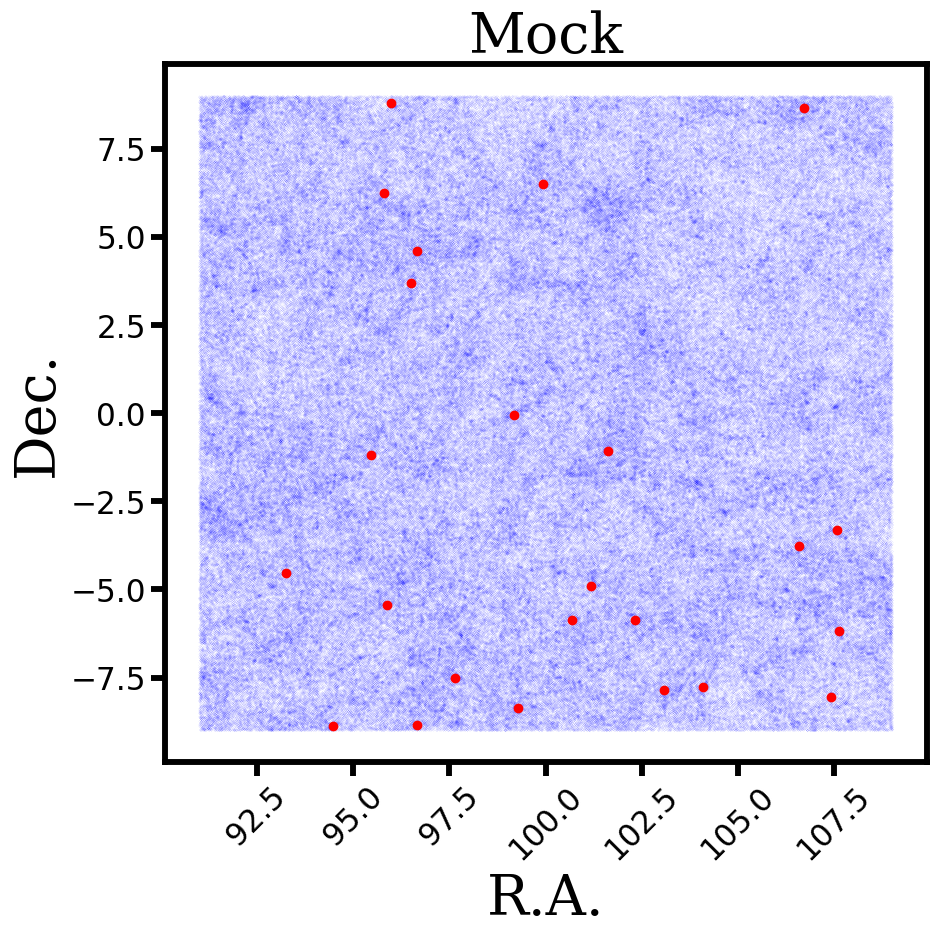

In [34]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

sc = ax.scatter(ra, dec, c="blue", s=0.0005)
ax.scatter(ra0_list, dec0_list, marker='o', color='red')
ax.set_xlabel("R.A.", fontdict=font)
ax.set_ylabel("Dec.", fontdict=font)
ax.set_title("Mock", fontdict=font)

ax.tick_params(axis='x', rotation=45)
    
fig.tight_layout(pad=3.0)

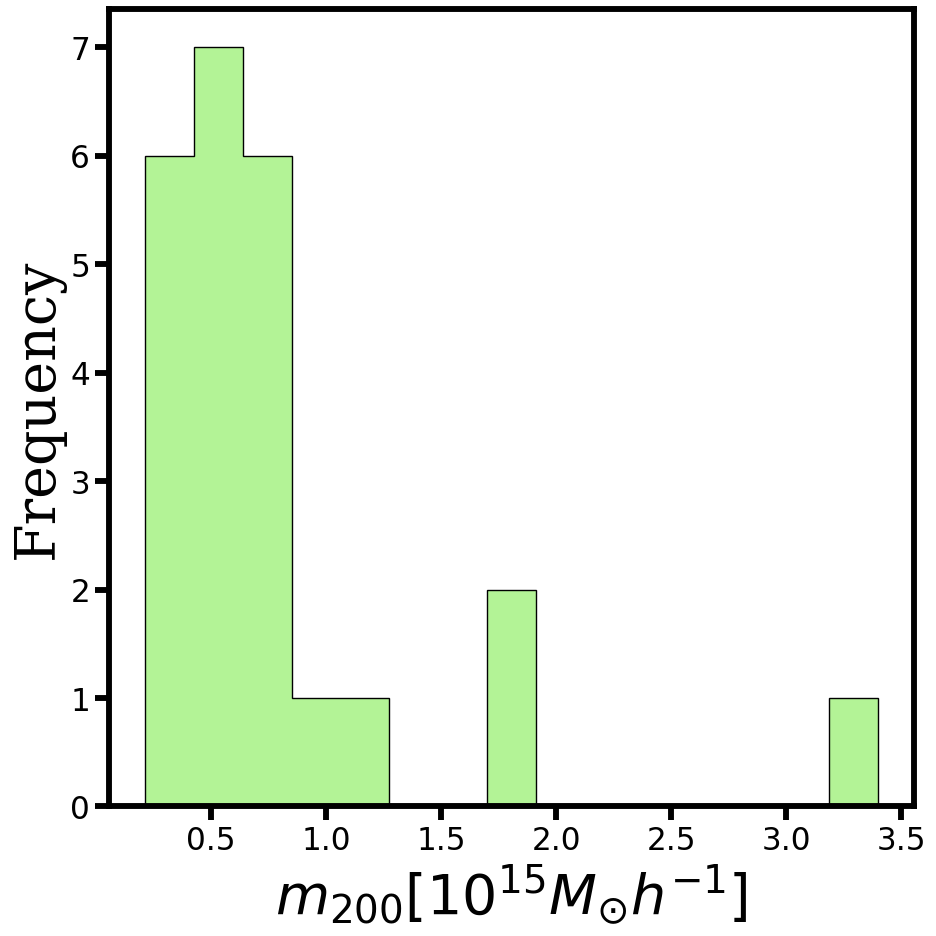

In [27]:
fig = plt.figure(figsize=(10, 10))

ax1 = fig.add_subplot(111)
ax1.hist(m200_list/1e15, bins=15, color=colors2[5], histtype='stepfilled', edgecolor='k')[2]
# ax1.axvline(cut_zp_median, color="red", lw=3, label="Median")
ax1.set_xlabel(r"$m_{200} [ 10^{15} M_{\odot} h^{-1}]$", fontdict=font)
ax1.set_ylabel("Frequency", fontdict=font)
# ax1.legend(fontsize=15, loc=2)


fig.tight_layout(pad=3.0)

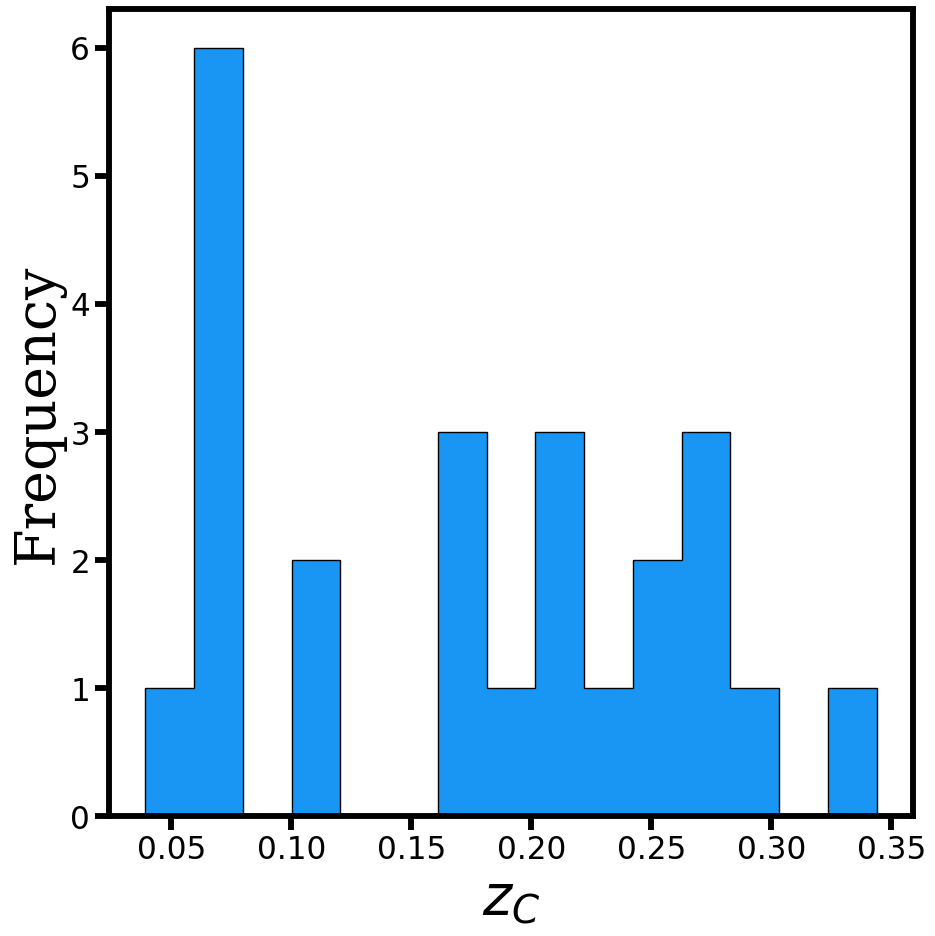

In [20]:
fig = plt.figure(figsize=(10, 10))

ax1 = fig.add_subplot(111)
ax1.hist(z_cluster_list, bins=15, color=colors2[1], histtype='stepfilled', edgecolor='k')[2]
# ax1.axvline(cut_zp_median, color="red", lw=3, label="Median")
ax1.set_xlabel(r"$z_C$", fontdict=font)
ax1.set_ylabel("Frequency", fontdict=font)
# ax1.legend(fontsize=15, loc=2)


fig.tight_layout(pad=3.0)